In [20]:
import numpy as np
import matplotlib.pyplot as plt


import jax
import jax.numpy as jnp
import optax
from tqdm import tqdm

In [21]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))
    

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T

    
    return samples

In [22]:
def sm_loss(params, samples):


    mu = params["mu"]
    L = params["L"]
    prec = L @ L.T


    centered = samples - mu
    prec2 = prec @ prec
    quad_terms = jnp.sum((centered @ prec2) * centered, axis=1)
    

    loss = 0.5 * jnp.mean(quad_terms) - jnp.trace(prec)

    
    return loss

In [23]:
def optimize_score_matching_with_tracking(samples, true_mu, true_cov, n_steps=1000, lr=1e-2, seed=0):


    d = samples.shape[1]
    key = jax.random.PRNGKey(seed)
    key_mu, key_L = jax.random.split(key)


    mu_init = jax.random.normal(key_mu, shape=(d,))
    L_init = jnp.eye(d) + 0.01 * jax.random.normal(key_L, shape=(d, d))
    L_init = jnp.tril(L_init)


    params = {"mu": mu_init, "L": L_init}
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)


    loss_grad_fn = jax.value_and_grad(sm_loss)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }


    for step in range(n_steps):
        loss_val, grads = loss_grad_fn(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        params["L"] = jnp.tril(params["L"])


        mu_hat = params["mu"]
        prec_hat = params["L"] @ params["L"].T
        cov_hat = jnp.linalg.inv(prec_hat)


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_hat))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_hat, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_hat, ord='fro'))
        

    return params, history

In [24]:
mu = jnp.array([1.0])


cov = jnp.array([
[1.0]
])

In [25]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


params_hat, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=800, lr=1e-2, seed = 0)


mu_hat = params_hat["mu"]
precision_hat = params_hat["L"] @ params_hat["L"].T
cov_hat = jnp.linalg.inv(precision_hat)

In [26]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(mu_hat, 4), jnp.linalg.norm(mu - mu_hat)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(cov_hat, 4), jnp.linalg.norm(cov - cov_hat)/jnp.linalg.norm(cov), "\n\n\n")

[1.] 

 [0.9776] 0.02236545 



[[1.]] 

 [[1.0069]] 0.0069032907 





In [27]:
history_np = {k: np.array(v) for k, v in history.items()}

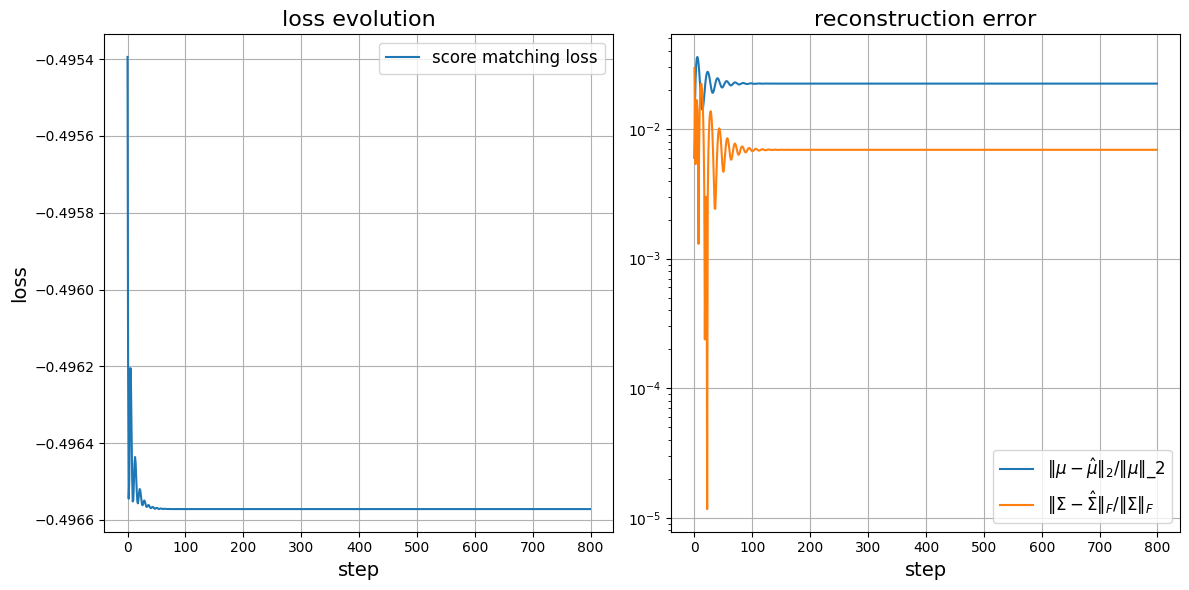

In [28]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|\_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [29]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=n_steps)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

100%|██████████| 40/40 [01:42<00:00,  2.56s/it]


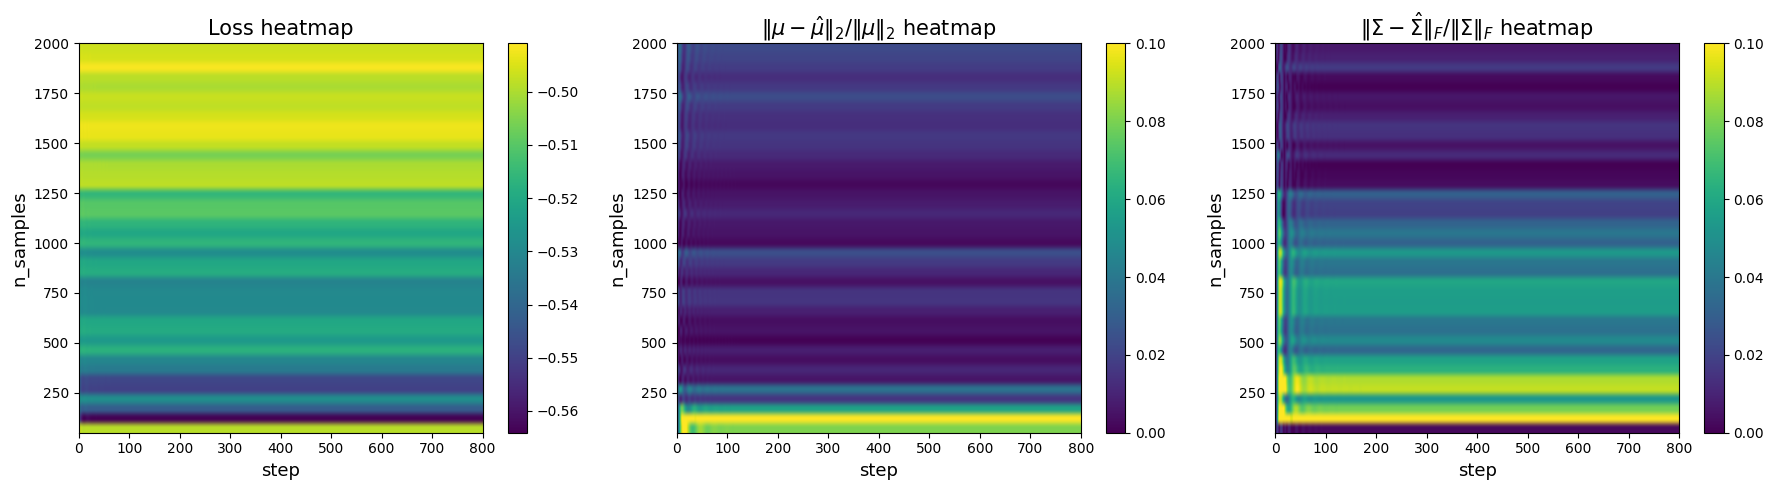

In [34]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=0.1)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=0.1)


plt.tight_layout()
plt.show()